In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from collections import defaultdict
import matplotlib.pyplot as plt

### X
level_name - one hot, target encoding

company - one hot, target encoding

title - word embedding, standardize somehow

location - one hot, country/state

years_exp - none

### A

race

gender

how to interpret NA?

### Y

salary

log(salary)

why log? being 10k off for individual that makes 60k means a lot more than being 10k off for individual that makes 600k

In [2]:
df = pd.read_csv('data/main-processed.tsv', sep='\t')
df['log_tc'] = df['tc'].apply(lambda x: np.log(x))

In [3]:
df['tag'].value_counts()

Full Stack                        16106
Distributed Systems (Back-End)    14007
API Development (Back-End)         9874
Web Development (Front-End)        4384
ML / AI                            3449
                                  ...  
Windows Developer                     1
Youtube                               1
Fintech                               1
SSD firmware                          1
camera sw                             1
Name: tag, Length: 1324, dtype: int64

<AxesSubplot:xlabel='yoe_total', ylabel='tc'>

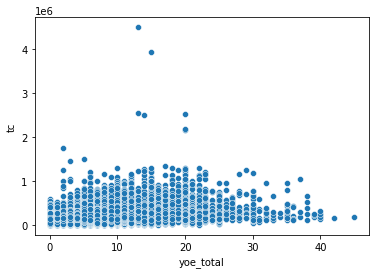

In [4]:
sns.scatterplot(x='yoe_total', y='tc', data=df)

<AxesSubplot:xlabel='yoe_total', ylabel='log_tc'>

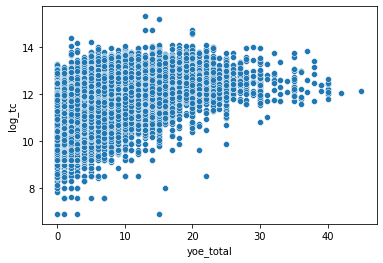

In [5]:
sns.scatterplot(x='yoe_total', y='log_tc', data=df)

In [6]:
df['company'].value_counts()

Amazon                  7213
Google                  3946
Microsoft               3927
Facebook                2584
Apple                   1217
                        ... 
Molex                      1
SimSpace                   1
Gerson Lehrman Group       1
Hoxton Analytics           1
General Assembly           1
Name: company, Length: 2963, dtype: int64

In [7]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, Normalizer


import category_encoders as ce

In [8]:
from sklearn.base import BaseEstimator, TransformerMixin
class Debug(BaseEstimator, TransformerMixin):

    def transform(self, X):
        print(X.shape)
        #print(X[0:5])
        # try:
        #     print(X.columns)
        # except:
        #     pass
        self.shape = X.shape
        # what other output you want
        return X

    def fit(self, X, y=None, **fit_params):
        return self


In [9]:
X = df.drop(['tc', 'base', 'stock', 'bonus', 'log_tc'], axis=1)
y = df['log_tc']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [10]:
pl = Pipeline([
    ('debug-1', Debug()),
    ('ct', ColumnTransformer([
        ('impute', SimpleImputer(strategy='median'), ['yoe_total']),
        #('onehot', OneHotEncoder(min_frequency=10, handle_unknown='infrequent_if_exist'), ['company', 'location', 'level_name']),
        ('target', ce.TargetEncoder(), ['company', 'location', 'level_name']),
    ], remainder='drop')),
    #('debug-2', Debug()),
    #('normalize', Normalizer()),
    ('debug-3', Debug()),
    ('reg', LinearRegression())
])

In [11]:
pl.fit(X_train, y_train)

(52263, 16)
(52263, 4)


Pipeline(steps=[('debug-1', Debug()),
                ('ct',
                 ColumnTransformer(transformers=[('impute',
                                                  SimpleImputer(strategy='median'),
                                                  ['yoe_total']),
                                                 ('target', TargetEncoder(),
                                                  ['company', 'location',
                                                   'level_name'])])),
                ('debug-3', Debug()), ('reg', LinearRegression())])

In [12]:
pl.score(X_test, y_test)

(13066, 16)
(13066, 4)


0.7291448978493648

In [13]:
pl.named_steps['reg'].coef_

array([0.02792763, 0.41670694, 0.73306675, 0.3449265 ])

In [14]:
pl.named_steps['reg'].intercept_

-6.088898256288227

In [19]:
def continuous_demo(X, A='gender', steps = 100):
    results = defaultdict(list)

    X = X.copy()
    X['predicted'] = pl.predict(X)
    bins = np.linspace(X['predicted'].min(), X['predicted'].max(), steps)

    for v in X[A].unique():
        results[v] = [(X[X[A] == v]['predicted'] > y_bin).mean() for y_bin in bins]
    results['bins'] = bins
    
    return results

In [20]:
results = continuous_demo(X)

(65329, 16)
(65329, 4)


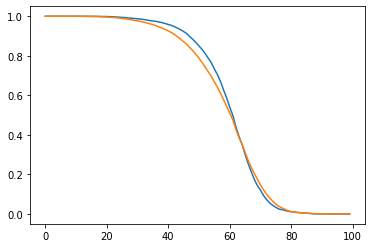

In [21]:
plt.plot(results['Female'])
plt.plot(results['Male'])

In [34]:
from sklearn.metrics import mean_squared_error

def bgl_mse(X, y, A='gender'):
    results = defaultdict(float)

    X = X.copy()
    y = y.copy()
    
    X['predicted'] = pl.predict(X)
    for v in X[A].unique():
        X_grp = X[X[A] == v]
        if len(X_grp):
            y_grp = y[X_grp.index]
            results[v] = mean_squared_error(X_grp['predicted'], y_grp)
    
    return results

In [35]:
def bgl_r2(X, y, A='gender'):
    results = defaultdict(float)

    X = X.copy()
    y = y.copy()
    for v in X[A].unique():
        X_grp = X[X[A] == v]
        if len(X_grp):
            y_grp = y[X_grp.index]
            results[v] = pl.score(X_grp, y_grp)
    
    return results

In [36]:
bgl_mse(X_test, y_test)

(13066, 16)
(13066, 4)


defaultdict(float,
            {'Female': 0.12505698783804342,
             'Male': 0.132743008405337,
             'Non-binary': 0.05736871079122871,
             'Other': 0.01525332084289814})

In [39]:
X_test['predicted'] = pl.predict(X_test)

(13066, 16)
(13066, 4)


In [41]:
X_test.groupby('gender')['predicted'].mean()

gender
Female        11.975611
Male          11.939969
Non-binary    11.953525
Other         11.932824
Name: predicted, dtype: float64